In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from copy import deepcopy

In [44]:
class leastSquaresGD:
    def __init__(self, error):
        self.x_original = None
        self.a_original = None
        self.b_original = None
        self.x = None
        self.a = None
        self.b = None
        self.initialTime = None
        self.error = error
        self.grad = None
        self.norm = None
        self.lam = None
        self.gr = None
        self.theta = None
        self.vanPlt = None
        self.AdapPlt = None
        self.LSPlt = None
        self.BazPlt = None
        self.Max = 0
        self.back_hi = 10**6
        self.back_lo = 0
        
    
    def generate(self, function, dim, vec_len, scale):
        for i in range(dim):
            globals()['X'+str(i)] = [0]*vec_len
        for j in range(vec_len):
            globals()['X'+str(0)][j] = (random.random()+1e-12)*scale
            y = function(globals()['X'+str(0)][j])
            noiz = 3
            for k in range(dim):
                globals()['X'+str(k)][j] = y + np.random.normal(0,noiz)
                noiz += 3
        A = np.array([globals()['X'+str(i)] for i in range(dim)]).T
        self.a_original = A
        self.x_original = np.random.rand(len(A[0]))*scale
        self.b_original = A @ self.x_original + np.random.normal(0,3,(A @ self.x_original).shape)
        
    def f(self, X):
        return 0.5 * np.linalg.norm(self.a @ X - self.b)**2
    def g(self, X):
        return self.a.T @ (self.a @ X - self.b)
    def Step(self):
        self.x = self.x - self.lam*self.grad
    
    
    def Vanilla(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        L = np.max( np.linalg.svd( self.a @ self.a.T ) [1] )
        self.lam = 1/L
        self.grad = self.g(self.x)
        self.norm = np.linalg.norm(self.grad)
        while self.norm > self.error:
            self.Step()
            self.grad = self.g(self.x)
            self.norm = np.linalg.norm(self.grad)
            self.gr.append(self.norm)
        print(' \n Vanilla Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, len(self.gr) , 'g', self.vanPlt, 'Vanilla')
        self.PrintResults()
    
    def Adaptive(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.lam = random.random()+1e-12
        self.theta = float(random.getrandbits(128))
        oldX = deepcopy(self.x)
        self.grad = self.g(self.x)
        self.Step()
        self.norm = np.linalg.norm(self.grad)
        while self.norm > self.error:
            oldLam = deepcopy(self.lam)
            min1 = np.sqrt(1 + self.theta)*self.lam
            min2 = ( np.linalg.norm( self.x - oldX ) ) \
                / ( 2 * np.linalg.norm( self.g(self.x) - self.g(oldX) ) )
            self.lam = np.min([min1,min2])
            oldX = deepcopy(self.x)
            self.Step() # update x
            self.theta = self.lam/oldLam
            self.grad = self.g(self.x)
            self.norm = np.linalg.norm(self.grad)
            self.gr.append(self.norm)
        print('\n Adaptive Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, len(self.gr) , 'y', self.AdapPlt, 'Adaptive')
        self.PrintResults()
    
    def BackTrack(self):
#         print('NEW BACKTRACK')
        sig = random.random()
        mu = random.uniform(sig,0.99999) 
        t = self.x - self.lam*self.grad
#         print('t:', t)
        while ( ( self.f(t) <= self.f(self.x) - self.lam*sig*np.linalg.norm(self.g(self.x)) ) \
               and ( np.linalg.norm(self.g(t)) >= mu*np.linalg.norm(self.g(self.x)) ) ):
            if self.f(t) > self.f(self.x) + self.lam*sig*np.linalg.norm(self.g(self.x)):
                self.back_hi = self.lam
                self.lam = 0.5*(self.back_lo + self.back_hi)
            elif np.linalg.norm(self.g(t)) < mu*np.linalg.norm(self.g(self.x)):
                self.back_lo = self.lam
                self.lam = 0.5*(self.back_lo + self.back_hi)
                
#             print('LAM:',self.lam)
            t = self.x - self.lam*self.grad
#             print('f:', self.f(t))
    
    def LineSearch(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.grad = self.g(self.x)
        self.norm = np.linalg.norm(self.grad)
        self.lam = random.random()
        self.BackTrack()
        k = 1000
        
        while self.norm > self.error:
            self.Step()
            self.grad =  self.g(self.x)
            self.norm = np.linalg.norm(self.grad)
            self.gr.append(self.norm)
            self.BackTrack()
            if len(self.gr) == k:
                self.SetPlots(k - 1000, len(self.gr), 'b', self.LSPlt, 'LineSearch')
                k += 1000
            if len(self.gr) > 10:
                if self.gr[-1] == self.gr[-2]:
                    print(len(self.gr))
                    print(self.gr[-1])
        print('Norms' , self.gr)
        print('\n Line Search Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, len(self.gr) , 'b', self.LSPlt, 'LineSearch')
        self.PrintResults()
    
    def Barzilai(self):
        self.initialTime = time.time()
        self.x = deepcopy(self.x_original)
        self.a = deepcopy(self.a_original)
        self.b = deepcopy(self.b_original)
        self.gr = []
        self.grad = self.g(self.x)
        self.lam = random.random()+1e-12
        oldX = deepcopy(self.x)
        self.Step()
        self.norm = np.linalg.norm(self.grad)
        while self.norm > self.error:
            oldLam = deepcopy(self.lam)
            self.lam = np.dot( self.x - oldX, self.g(self.x) - self.g(oldX) ) \
                        / np.linalg.norm(self.g(self.x) - self.g(oldX))**2
            oldX = deepcopy(self.x)
            self.Step()
            self.grad = self.g(self.x)
            self.norm =  np.linalg.norm(self.grad)
            self.gr.append( self.norm)
        print('\n Barzilai-Borwein Gradient Descent:')
        print('_____________________________________________')
        if len(self.gr) > self.Max:
            self.Max = deepcopy(len(self.gr))
        self.SetPlots(0, len(self.gr) , 'r', self.BazPlt, 'Barzilai')
        self.PrintResults()
    
    def SetPlots(self, Min, Max, colour, name, label):
        name = plt.plot( range( Min, Max ) , self.gr[Min:Max] , c = colour , label = label)
    def PrintPlots(self):
        self.vanPlt
        self.AdapPlt
        self.LSPlt
        self.BazPlt
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.legend(loc='best')
        plt.title(label = 'Norm of Gradient in domain [{}, {}]'.format(0,self.Max) )
        plt.show()
    def PrintResults(self):
        print('At final iteration k =', len(self.gr), ':')
        print('x vector is:', self.x)
        print('Gradient Norm is:', np.linalg.norm(self.grad))
        print('Time taken:', time.time() - self.initialTime)
        print('Final Lambda value: ', self.lam)

In [45]:
def linFunc(x):
    return 2*x + 5

34
inf
35
inf
36
inf
37
inf
38
inf
39
inf
40
inf
41
inf
42
inf
43
inf
44
inf
45
inf
46
inf
47
inf
48
inf
49
inf
50
inf
51
inf
52
inf
53
inf
54
inf
55
inf
56
inf
57
inf
58
inf
59
inf
60
inf
61
inf
62
inf
63
inf
64
inf
65
inf
66
inf
Norms [50969540.90428098, 1632735826534.4204, 6.198797247805789e+16, 2.4863942131752407e+21, 1.0152451564334295e+26, 4.1716070274556155e+30, 1.7182339560340986e+35, 7.084392978689275e+39, 2.9223623255336848e+44, 1.205817578877284e+49, 4.9762418228335555e+53, 2.0538581368747305e+58, 8.477630541153162e+62, 3.499486070250521e+67, 1.4446185723100468e+72, 5.963709005102179e+76, 2.462013600491132e+81, 1.0164184367272364e+86, 4.196243677571944e+90, 1.7324210002788303e+95, 7.152364199900331e+99, 2.952897631138966e+104, 1.2191274519617658e+109, 5.033282380867297e+113, 2.0780432630339994e+118, 8.57943530823166e+122, 3.542121446045058e+127, 1.4624083598081744e+132, 6.037737511211027e+136, 2.492757672418995e+141, 1.0291675758912375e+146, 4.2490542840426395e+150, inf, inf

<ipython-input-44-127ab1b1f52c>:107: RuntimeWarning: invalid value encountered in double_scalars
  while ( ( self.f(t) <= self.f(self.x) - self.lam*sig*np.linalg.norm(self.g(self.x)) ) \
<ipython-input-44-127ab1b1f52c>:41: RuntimeWarning: overflow encountered in matmul
  return 0.5 * np.linalg.norm(self.a @ X - self.b)**2
<ipython-input-44-127ab1b1f52c>:41: RuntimeWarning: invalid value encountered in matmul
  return 0.5 * np.linalg.norm(self.a @ X - self.b)**2
<ipython-input-44-127ab1b1f52c>:43: RuntimeWarning: overflow encountered in matmul
  return self.a.T @ (self.a @ X - self.b)
<ipython-input-44-127ab1b1f52c>:43: RuntimeWarning: invalid value encountered in matmul
  return self.a.T @ (self.a @ X - self.b)


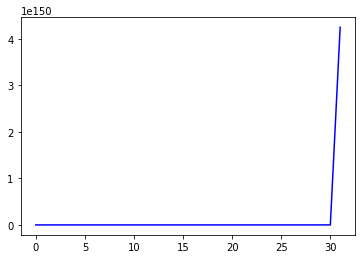

In [46]:
G = leastSquaresGD(1e-2)
G.generate(linFunc,10,100, 1)
G.LineSearch()

In [7]:
random.random()+1e-12

0.8828427309381599

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 684 :
x vector is: [0.16652021 0.19302652 0.47528352 0.46785039 0.50338701 0.63711373
 0.4970159  0.2159171  0.40296115 0.55260689]
Gradient Norm is: 0.0009866340138953102
Time taken: 0.04092264175415039
Final Lambda value:  1.0765953040416087e-05

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 260 :
x vector is: [0.16652021 0.19302652 0.47528352 0.46785038 0.50338701 0.63711373
 0.4970159  0.2159171  0.40296115 0.55260689]
Gradient Norm is: 0.0009999549748051406
Time taken: 0.03287386894226074
Final Lambda value:  0.0001230344260603093

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 354 :
x vector is: [0.16652118 0.19302602 0.47528341 0.46785033 0.50338697 0.63711377
 0.4970159  0.21591709 0.40296114 0.5526069 ]
Gradient Norm is: 0.000811976230858842
Time taken: 0.02293848991394043
Final

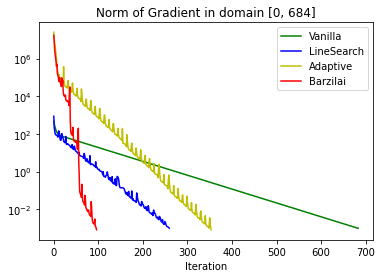

In [20]:
G = leastSquaresGD(1e-3)
G.generate(linFunc,10,100, 1)
G.Vanilla()
G.LineSearch()
G.Adaptive()
G.Barzilai()
G.PrintPlots()

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 117029 :
x vector is: [1.50247598 3.22438961 4.13564111 3.09076269 3.79547147 8.18463182
 6.87657931 4.88158754 4.35962825 6.747912   2.25488024 0.44517342
 9.50996088 6.00418347 5.73264878 8.82929558 6.12434503 3.59469119
 5.43760263 2.2771975  2.90768964 4.1944005  3.27137367 0.55224305
 2.05476249 4.51615608 3.2596148  2.71207107 7.50468836 2.90674596
 7.29805693 4.17826228 5.07600889 7.83252513 8.15309756 8.73238915
 3.96241129 7.08311278 8.26951979 3.2840348  8.86432838 1.89067636
 4.19960364 8.31592321 3.7248556  9.10436967 2.17990421 8.27587319
 8.43337868 6.44883872 7.67277682 0.2637033  5.04407738 4.19887695
 0.19376249 9.23489955 9.81715642 3.19654151 2.80378087 1.59860927
 4.52040889 9.9089658  1.56646513 8.70605546 8.35648295 7.19112072
 2.36106289 1.68129946 1.83396748 1.62590814 1.60028269 2.56218428
 3.78191949 2.70067041 8.58300284 2.48051617 2.65205024 5.15365766
 4.628524

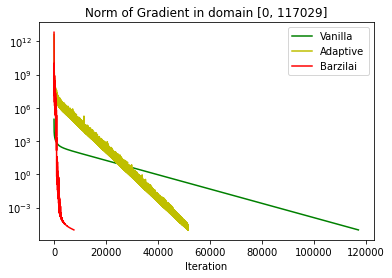

In [23]:
G = leastSquaresGD(1e-5)
G.generate(linFunc,100,1000, 10)
G.Vanilla()
# G.LineSearch()
G.Adaptive()
G.Barzilai()
G.PrintPlots()

<ipython-input-2-ee0c423419d2>:141: RuntimeWarning: invalid value encountered in double_scalars
  self.lam = np.dot( self.x - oldX, self.LinRegGrad(self.x) - self.LinRegGrad(oldX) ) \



 Barzilai-Borwein Gradient Descent:
_____________________________________________
At final iteration k = 11721 :
x vector is: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
Gradient Norm is: nan
Time taken: 12.256787776947021
Final Lambda value:  nan


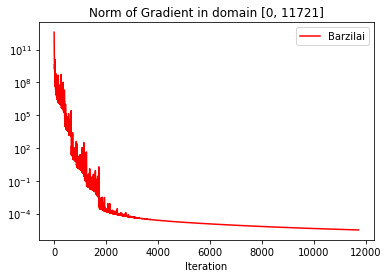

In [5]:
G = leastSquaresGD(1e-8)
G.generate(linFunc,100,1000, 10)
G.Barzilai()
G.PrintPlots()